# ASSIGNED Adiabatic batch reactor

The reaction $A + B \rightleftharpoons C$ is carried out in an adiabatic, constant volume batch reactor. The rate law is
r = k1 \* C\_A \* C\_B - k2 \* C\_C

<table border="2" cellspacing="0" cellpadding="6" rules="groups" frame="hsides">


<colgroup>
<col  class="org-left" />

<col  class="org-left" />
</colgroup>
<tbody>
<tr>
<td class="org-left">Initial temperature = 100 °C</td>
<td class="org-left">&#xa0;</td>
</tr>


<tr>
<td class="org-left">k1 (373K) = 2e-3 L/mol/s</td>
<td class="org-left">E1 = 100 kJ/mol</td>
</tr>


<tr>
<td class="org-left">k2 (373K) = 3e-5 1/s</td>
<td class="org-left">E2 = 150 kJ/mol</td>
</tr>


<tr>
<td class="org-left">CA0 = 0.1 mol / L</td>
<td class="org-left">CpA = 25 J/mol/K</td>
</tr>


<tr>
<td class="org-left">CB0 = 0.125 mol / L</td>
<td class="org-left">CpB = 25 J/mol/K</td>
</tr>


<tr>
<td class="org-left">Hrx (298K) = -40 kJ /mol A</td>
<td class="org-left">CpC = 40 J/mol/K</td>
</tr>
</tbody>
</table>

1.  Plot the concentrations and temperature as a function of time. Explain what you see.
2.  Plot the equilibrium conversion as a function of temperature

## solution

### Part a

We need to setup coupled mole and energy balances for the species, and then solve them.
Here is the data provided.

In [1]:
import numpy as np
from scipy.integrate import odeint

T0 = 100.0 + 273.15  # K
k1_373 = 0.002
E1 = 100.0       # kJ/mol
k2_373 = 3.0e-5
E2 = 150.0       # kJ/mol
R = 8.314e-3

# initial concentrations
Ca0 = 0.1
Cb0 = 0.125
Cc0 = 0.0

# thermal properties
Hrx_298 = -40.0  # kJ/mol
Cpa = 0.025      # kJ/mol/K
Cpb = 0.025      # kJ/mol/K
Cpc = 0.040      # kJ/mol/K

dCp = Cpc - Cpa - Cpb

Now define the mole/energy balances.

In [1]:
def ode(Y, t):
    Ca, Cb, Cc, T = Y  # constant volume, so we can use concentration

    # First the temperature dependent rate constants
    k1 = k1_373 * np.exp(-E1 / R * (1.0 / T - 1.0 / 373.0))
    k2 = k2_373 * np.exp(-E2 / R * (1.0 / T - 1.0 / 373.0))

    # Then the rate
    r = k1 * Ca * Cb - k2 * Cc
    ra = rb = -r
    rc = r

    # The mole balance
    dCadt = ra
    dCbdt = rb
    dCcdt = rc

    # energy balance
    # First the reaction enthalpy at the temperature
    Hrx = Hrx_298 + dCp * (T - T0)

    dTdt = (-Hrx * r) / (Ca * Cpa + Cb * Cpb + Cc * Cpc)
    return (dCadt, dCbdt, dCcdt, dTdt)

tspan = np.linspace(0, 100, 200)
Y0 = [Ca0, Cb0, Cc0, T0]
sol = odeint(ode, Y0, tspan)

Ca = sol[:, 0]
Cb = sol[:, 1]
Cc = sol[:, 2]
T = sol[:, 3]

Now make the plots.

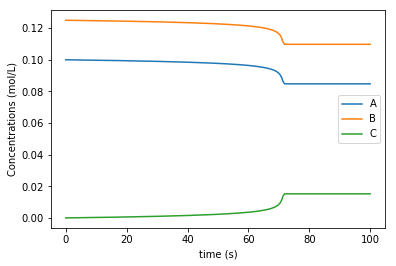

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(tspan, Ca, tspan, Cb, tspan, Cc)
plt.xlabel('time (s)')
plt.ylabel('Concentrations (mol/L)')
plt.legend(['A', 'B', 'C'], loc='best')

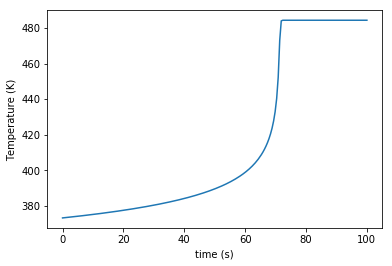

In [1]:
plt.figure()
plt.plot(tspan, T)
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')

Note that the temperature rises very quickly. The reaction appears to reach equilibrium very abruptly. It does actually reach equilibrium in a smooth and continuous way, but over a very short time scale. You have to use a very dense integration grid (e.g. 20000 points) and zoom into the microsecond time scale to see that it is smooth.

### part b

By stoichiometry we have:
$$K = Cc / (Ca * Cb)$$
let X be the reaction conversion.

-   $CA = Ca0 * (1 - X)$
-   $CB = Cbo - Ca0 * X$
-   $Cc = Ca0 * X$

then:
we solve:
$K = k1/k2 = Ca0 * X / (Ca0(1 - X) * (Cb0 - Ca0 * X))$
for X as a function of temperature.

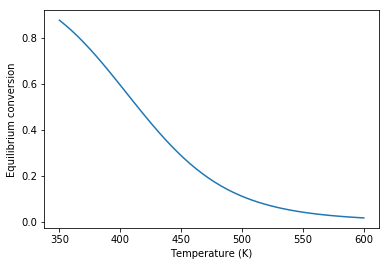

In [1]:
T0 = 100.0 + 273.15  # K
k1_373 = 0.002
E1 = 100.0       # kJ/mol
k2_373 = 3.0e-5
E2 = 150.0       # kJ/mol
R = 8.314e-3

Ca0 = 0.1
Cb0 = 0.125
Cc0 = 0.0
Hrx_298 = -40.0  # kJ/mol
Cpa = 0.025      # kJ/mol/K
Cpb = 0.025      # kJ/mol/K
Cpc = 0.040      # kJ/mol/K

dCp = Cpc - Cpa - Cpb

from scipy.optimize import fsolve

Tspan = np.linspace(350, 600)

def objective(X, T):
    # X is a reaction extent, not a fractional conversion
    k1 = k1_373 * np.exp(-E1 / R * (1.0 / T - 1.0 / 373.0))
    k2 = k2_373 * np.exp(-E2 / R * (1.0 / T - 1.0 / 373.0))

    K = k1 / k2
    return K -  Ca0 * X / (Ca0 * (1 - X) * (Cb0 - Ca0 *X))

XEQ = np.empty(Tspan.shape)
for i, T in enumerate(Tspan):
    guess = 1e-6
    XEQ[i], = fsolve(objective, guess, args=(T,))
    guess = XEQ[i]

plt.figure()
plt.plot(Tspan, XEQ)
plt.xlabel('Temperature (K)')
plt.ylabel('Equilibrium conversion')

There is an alternative approach, which looks like this. We can use the reaction enthalpy to estimate the temperature dependent equilibrium constant. The results are not exactly the same but they are similar. In principle they should be the same, but rounding errors/uncertainty in the rate constants, activation energies, heat capacities and heat of reaction prevent them from being identical. These quantities are not actually all independent of each other.

Here I only show the differences in $K$. you could use either $K$ to derive the conversion above.

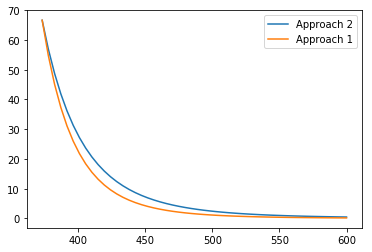

In [1]:
def dlnKdT(lnK, T):
    Hrx = Hrx_298 + dCp * (T - T0)
    return Hrx / R / T**2

K373 = k1_373 / k2_373

from scipy.integrate import odeint

Tspan2 = np.linspace(373, 600)
sol = odeint(dlnKdT, np.log(K373), Tspan2)

Kalt = np.exp(sol)

k1 = k1_373 * np.exp(-E1 / R * (1.0 / Tspan2 - 1.0 / 373.0))
k2 = k2_373 * np.exp(-E2 / R * (1.0 / Tspan2 - 1.0 / 373.0))

Kori = k1 / k2

plt.plot(Tspan2, Kalt, Tspan2, Kori)
plt.legend(['Approach 2', 'Approach 1'])